companies_allFeatures.csv  demo.pdf	     test.csv
companies.csv		   dev.csv	     train.csv
comp_filter.csv		   investments.csv   train_upsampled_shuffled.csv
comp_plus_InvestorNum.csv  ml-project.ipynb
(66368, 14)
operating    53034
closed        6238
acquired      5549
ipo           1547
Name: status, dtype: int64


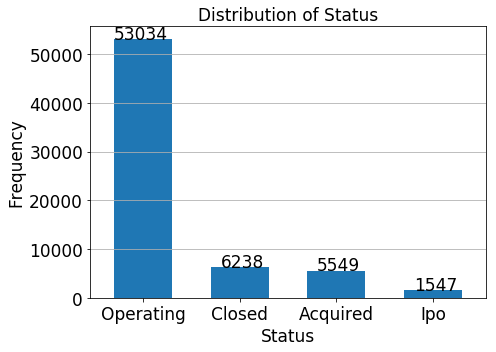

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import os


companies = pd.read_csv("companies.csv")

print(companies.shape)
companies.head()

classes = pd.value_counts(companies['status'])
print(classes)
size=17
plt.figure(figsize=(7,5))
ax=classes.plot(kind = 'bar', rot=0, fontsize=size, width=0.6)
labels = ['Operating', 'Closed', 'Acquired', 'Ipo']
plt.title("Distribution of Status", fontsize=size)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Status", fontsize=size)
plt.ylabel("Frequency", fontsize=size)
plt.grid(axis='y')
x=0
for i in ax.patches:
    if x==0:
      j=0
    else:
      j=0.1
    ax.text(i.get_x()+j, i.get_height()+20, str(i.get_height()), fontsize=size)
    x=x+1

plt.tight_layout()
plt.savefig("data.pdf")
plt.show()


comp_filter['label'] = 0
comp_filter.loc[comp_filter.status == 'ipo', 'label'] = 1
comp_filter.loc[comp_filter.status == 'acquired', 'label'] = 1
comp_filter.head()

comp_filter.to_csv("comp_filter.csv", index=False, encoding='utf8')
df = pd.read_csv('comp_filter.csv')
df.head()

investor = pd.read_csv('investments.csv')
investor_num = investor[['company_permalink',
                         'investor_permalink']].groupby(['company_permalink']).agg(['count'])

comp_plus_InvestorNum = pd.merge(how='inner',left=df, right=investor_num, 
                                 left_on='permalink', right_on='company_permalink')

comp_plus_InvestorNum.to_csv('comp_plus_InvestorNum.csv',index=False, encoding='utf8')


df = pd.read_csv('comp_plus_InvestorNum.csv')
df.head()


df.rename(columns={"('investor_permalink', 'count')": "Num_of_investor"}, inplace=True)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')

###funding_duration between 'first_funding_at' and 'last_funding_at'
t1 = pd.to_datetime(df.first_funding_at, errors='coerce')
t1 = pd.to_timedelta(t1).dt.days
t2 = pd.to_datetime(df.last_funding_at, errors='coerce')
t2 = pd.to_timedelta(t2).dt.days


df['funding_duration'] = t2 - t1

# convert datetime type 
df['first_funding_at_UTC'] = t1
df['last_funding_at_UTC'] = t2

df.info()

df.to_csv('companies_allFeatures.csv', index=False, encoding='utf8')


import sklearn
from scipy.sparse import hstack
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample, shuffle
from sklearn import datasets
from sklearn.model_selection import train_test_split

df = pd.read_csv('companies_allFeatures.csv')


#meaningful features
df = df.drop(columns=['permalink', 'name', 'homepage_url', 'status', 'state_code',
                      'region','city', 'founded_at', 'first_funding_at','last_funding_at'])

df_clean = df.dropna()

df.info()
df_clean.info()

df_clean.iloc[23]

#split the dataset into tain, dev, and test set.
X = df_clean.drop(columns=['label'])
y = df_clean['label']
X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.1, random_state=2,
                                                      stratify=y, shuffle=True)
X_dev, X_test, y_dev, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=2,
                                            shuffle=False)

df = X_dev
df['label'] = y_dev
df.to_csv('dev.csv')

df = X_test
df['label'] = y_test
df.to_csv('test.csv')

df = X_train
df['label'] = y_train
df.to_csv('train.csv')

df = pd.read_csv('train.csv', )
df.shape

# Separate majority and minority classes
df_majority = df[df.label==0]
print(df_majority.shape)
df_minority = df[df.label==1]
print(df_minority.shape)
n = df.label.value_counts()[0]
print(n)


# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n,    # to match majority class
                                 random_state=123) # reproducible results

print("# after upsampled")
print(df_minority_upsampled.shape)

# downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,     # sample with replacement
#                                  n_samples=n,    # to match majority class
#                                  random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

print("after concat")
print(df_upsampled.shape)

df_upsampled = shuffle(df_upsampled)


n = df_upsampled.label.value_counts()[1]
print(n)

df_upsampled.to_csv('train_upsampled_shuffled.csv', index=False)

df_upsampled.shape

df = pd.read_csv('train_upsampled_shuffled.csv')
X_train = df.iloc[:,1:-1]
y_train = df.iloc[:,-1]


df_dev = pd.read_csv('dev.csv')
X_dev = df_dev.iloc[:,1:-1]
y_dev = df_dev.iloc[:,-1]

df_test = pd.read_csv('test.csv')
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

df_dev.shape

X_dev.shape

X_train_text = X_train.category_list
X_train_country = X_train.country_code
X_train_nums = X_train.drop(columns=['category_list','country_code'])
#################
X_dev_text = X_dev.category_list
X_dev_country = X_dev.country_code
X_dev_nums = X_dev.drop(columns=['category_list','country_code'])
##################
X_test_text = X_test.category_list
X_test_country = X_test.country_code
X_test_nums = X_test.drop(columns=['category_list','country_code'])
##################

print(X_train_nums.columns.values)

####text feature
X_train.category_list = X_train.category_list.astype(str)
vectorizer1 = CountVectorizer(min_df=5)
vectorizer1.fit(X_train.category_list)

X_train_text = vectorizer1.transform(X_train.category_list)
X_dev_text = vectorizer1.transform(X_dev.category_list)
X_test_text = vectorizer1.transform(X_test.category_list)


#####categorical feature
X_train.country_code= X_train.country_code.astype(str)
vectorizer2 = CountVectorizer(min_df=1)
vectorizer2.fit(X_train.category_list)
X_train_country = vectorizer2.transform(X_train.country_code)
X_dev_country = vectorizer2.transform(X_dev.country_code)
X_test_country = vectorizer2.transform(X_test.country_code)


scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train_nums)
X_train_nums = scaler.transform(X_train_nums)
X_dev_nums = scaler.transform(X_dev_nums)
X_test_nums = scaler.transform(X_test_nums)


print(X_train_nums.shape)
print(X_train_country.shape)
print(X_train_text.shape)
#####concatinate inputs
X_train_con = hstack([X_train_nums, X_train_country, X_train_text])
X_dev_con = hstack([X_dev_nums, X_dev_country, X_dev_text])
X_test_con = hstack([X_test_nums, X_test_country, X_test_text])

In [ ]:

from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split




import sklearn
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

c=np.arange(1, 101, 10)
gamma=np.array([1/108, 1/54, 1/27, 2/27, 4/27])
depth=np.arange(991, 2991, 100)

def train_svm(train_data, test_data, train_label, test_label, c_val, type, g):
    if type=='gamma':
        classifier = svm.SVC(C=c_val, kernel='rbf', gamma=g)
    else:
        classifier = svm.SVC(C=c_val, kernel='rbf', gamma='auto')
    classifier.fit(train_data, train_label)
    predicted_label = classifier.predict(test_data)
    acc=accuracy_score(predicted_label, test_label)
    return acc

def plot_acc(avg_err, type):
    global c
    global gamma
    if type=='c':
        x=c
    elif type=='gamma':
        x=gamma
    elif type=="tree":
        x=depth
    fig=plt.figure(1)
    ax = fig.gca()
    ax.set_xlim([min(x), max(x)])
    if type=='c':
        ax.set_xlabel('C')
        ax.set_title('C vs Accuracy')
        # plt.xscale('log')
        # plt.grid(True, which="both")
    elif type=='gamma':
        ax.set_xticks(x)
        ax.set_xlabel('Gamma')
        ax.set_title('Gamma vs Accuracy')
    elif type=="tree":
        ax.set_xticks(x)
        ax.set_xlabel('Depth')
        ax.set_title('Depth vs Accuracy')
    plt.grid()
    ax.set_ylabel('Accuracy')
    plt.plot(x, avg_err, 'r')
    plt.show()

def train_tree(train_data, test_data, train_label, test_label, depth):
    classifier = DecisionTreeClassifier(max_depth=depth)
    classifier.fit(train_data, train_label)
    predicted_label = classifier.predict(test_data)
    acc=accuracy_score(predicted_label, test_label)
    return acc
    
def kfold(data, label, c_val, type, gamma, *args, **kwargs):
    j=0
    err=np.zeros((1, 10))
    depth = kwargs.get('depth', None)
    kfold = KFold(n_splits=10, shuffle=False)
    for train_index, test_index in kfold.split(data):
        print("k: ", j)
        test_label=label[test_index]
        test_data=data[test_index, :]
        train_data=data[train_index, :]
        train_label=label[train_index]
        if type=="tree":
          err[0, j]=train_tree(train_data, test_data, train_label, test_label, depth)
        else:
          err[0, j]=train_svm(train_data, test_data, train_label, test_label, c_val, type, gamma)
        j=j+1
    return err

def evaluate(iter, data, label , c, type, err, *args, **kwargs):
    gamma = kwargs.get('gamma', None)
    d = kwargs.get('depth', None)
    if iter==0:
        err=kfold(data, label, c, type, gamma, depth=d)
    else:
        err=np.append(err, kfold(data, label, c, type, gamma), axis=0)
    return err


def evaluate_c(data, label, type):
    err=np.array([])
    global c
    i=0
    for c_val in c:
        print("C: {0}".format(c_val))
        err=evaluate(i, data, label, c_val, type, err)
        i=i+1
    return err

def evaluate_gamma(data, label, type, c):
    global gamma
    err=np.array([])
    i=0
    for g in gamma:
        print("gamma: {0}, C: {1}".format(g, c))
        err=evaluate(i, data, label, c, type, err, gamma=g)
        i=i+1
    return err
def evaluate_tree(data, label, type, c):
    global depth
    err=np.array([])
    i=0
    for d in depth:
        print("depth: {0}".format(d))
        err=evaluate(i, data, label, c, type, err, depth=d)
        i=i+1
    return err

    return err
def train_model(data, label, type, *args, **kwargs):
    # train=shuffle(train, random_state=0)
    err=np.array([])
    c = kwargs.get('best_c', None)
    i=0
    if type=='c':
        err=evaluate_c(data, label, type)
    elif type=='gamma':
        err=evaluate_gamma(data, label, type, c)
    elif type=='all':
        err= evaluate(i, data, label, c, type, err)
    elif type=="tree":
        err=evaluate_tree(data, label, type, c)
    avg_err=np.mean(err, axis=1)
    if type=='all':
        print(avg_err)
    else:
        plot_acc(avg_err, type)

(1635, 1479)
0.7859327217125383
0.32170542635658916
0.5982523444160273


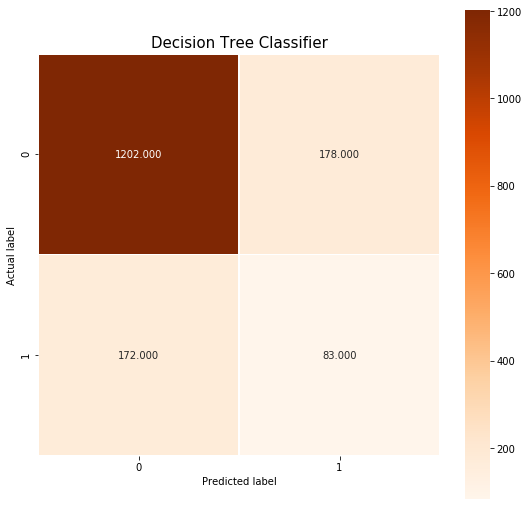

TPR: 0.3254901960784314
FPR: 0.1289855072463768
recall: 0.3254901960784314
precision: 0.31800766283524906
f1:  0.32170542635658916


In [ ]:
from sklearn.svm import SVC
from sklearn import metrics 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from scipy import interp
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

model_RF = DecisionTreeClassifier(max_depth=1391)
model_RF.fit(X_train_con, y_train)
print(X_dev_con.shape)
y_pred = model_RF.predict(X_dev_con)
acc = accuracy_score(y_dev, y_pred)

f1 = f1_score(y_dev, y_pred)
auc=roc_auc_score(y_dev, y_pred)
print(acc)
print(f1)
print(auc)
cm = confusion_matrix(y_dev, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Decision Tree Classifier', size = 15);
plt.show()


tpr = cm[1,1]/(cm[1,1] + cm[1,0])
fpr = cm[0,1]/(cm[0,1] + cm[0,0])
recall=cm[1,1]/(cm[1,1] + cm[1,0])
precision=cm[1,1]/(cm[1,1] + cm[0,1])
print('TPR: {0}'.format(tpr))
print('FPR: {0}'.format(fpr))
print("recall:", recall )
print("precision:", precision )
print("f1: ", f1)

(1635, 1479)
0.6250759878419453
0.8006116207951071
0.3531746031746032


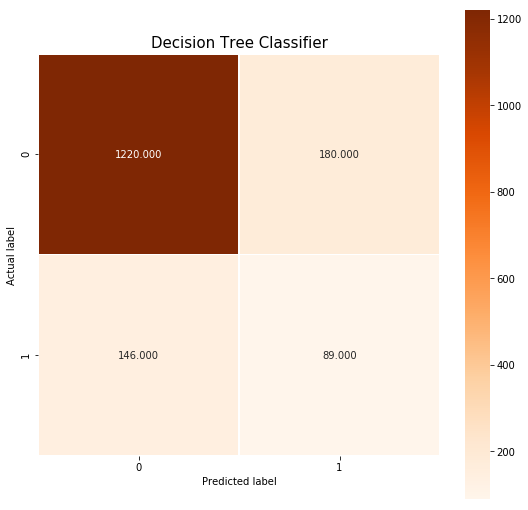

TPR: 0.37872340425531914
FPR: 0.12857142857142856
recall: 0.37872340425531914
precision: 0.3308550185873606
f1:  0.3531746031746032


In [ ]:
print(X_dev_con.shape)
y_pred = model_RF.predict(X_test_con)
acc = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
auc=roc_auc_score(y_test, y_pred)
print(auc)
print(acc)
print(f1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Decision Tree Classifier', size = 15);
plt.show()


tpr = cm[1,1]/(cm[1,1] + cm[1,0])
fpr = cm[0,1]/(cm[0,1] + cm[0,0])
recall=cm[1,1]/(cm[1,1] + cm[1,0])
precision=cm[1,1]/(cm[1,1] + cm[0,1])
print('TPR: {0}'.format(tpr))
print('FPR: {0}'.format(fpr))
print("recall:", recall )
print("precision:", precision )
print("f1: ", f1)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
# X=X_train_con
# y=y_train
# forest = ExtraTreesClassifier(n_estimators=2500,
#                               random_state=0)
# forest.fit(X, y)
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]
print("Feature ranking:")
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
lst=[]
stds=[]
lst.append(sum(importances[6:811]))
stds.append(np.sqrt(np.sum(np.square(std[6:811]))/2))
lst.append(sum(importances[811:]))
stds.append(np.sqrt(np.sum(np.square(std[811:]))/5))
lst=np.array(lst+importances[0:6].tolist())
stds=np.array(stds+std[0:6].tolist())
indices2 = np.argsort(lst)[::-1]
args=np.array(['Country\nCode', 'Category\nList', 'Funding\nTotal\n(USD)', 'Funding\nRounds',
        'Num of\nInvestor', 'Funding\nDuration', 'First Funding\n at UTC', 'Last Funding\n at UTC'])

size=27
plt.figure(figsize=(20,8))
plt.rcParams.update({'font.size': size})
plt.title("Importance of Features",fontsize=size)
# plt.xlabel('Features')
plt.ylabel('Percentage')
plt.bar(range(lst.shape[0]), lst[indices2]*100,
       color="r", yerr=stds[indices2]*100, align="center", capsize=10)
plt.xticks(range(lst.shape[0]), args[indices2], rotation=-30, color='black')
plt.yticks(color='black')
plt.tight_layout()
plt.savefig('demo.pdf', transparent=True)
plt.show()
!pwd